# MODULE 1 : CNN MODEL CREATION FOR ISIC2019 SKIN DISEASES IMAGE DATA SET

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import random
from keras.models import load_model

### Importing Skin Cancer  Image Data

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

1543
61


In [5]:
batch_size = 64
img_height = 224
img_width = 224

In [15]:
## train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 1543 files belonging to 6 classes.
Using 1235 files for training.


In [16]:
## validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 1543 files belonging to 6 classes.
Using 308 files for validation.


In [6]:
# Listing out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'melanoma', 'nevus', 'seborrheic keratosis', 'squamous cell carcinoma']


### Data Visualtization

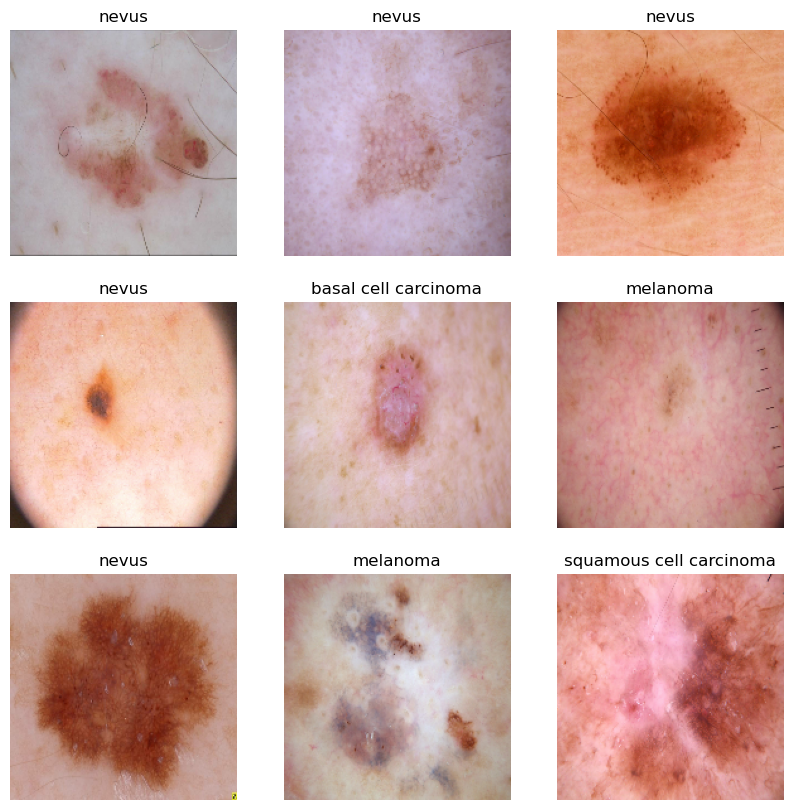

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [13]:
from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesion_list))

1543


In [14]:
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('skin-cancer\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('skin-cancer\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis')]


In [15]:
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,skin-cancer\Skin cancer ISIC The International...,actinic keratosis
1,skin-cancer\Skin cancer ISIC The International...,actinic keratosis
2,skin-cancer\Skin cancer ISIC The International...,actinic keratosis
3,skin-cancer\Skin cancer ISIC The International...,actinic keratosis
4,skin-cancer\Skin cancer ISIC The International...,actinic keratosis


In [16]:
original_df[['Label']].value_counts()

Label                  
melanoma                   438
basal cell carcinoma       376
nevus                      357
squamous cell carcinoma    181
actinic keratosis          114
seborrheic keratosis        77
dtype: int64

In [17]:
original_df[['Label']].value_counts(normalize=True)

Label                  
melanoma                   0.283863
basal cell carcinoma       0.243681
nevus                      0.231367
squamous cell carcinoma    0.117304
actinic keratosis          0.073882
seborrheic keratosis       0.049903
dtype: float64

total training image count = 1543 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.07388204795852236
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.2436811406351264
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.2838626053143227
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.23136746597537264
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.049902786779001944
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.11730395333765392
-------------------------------------


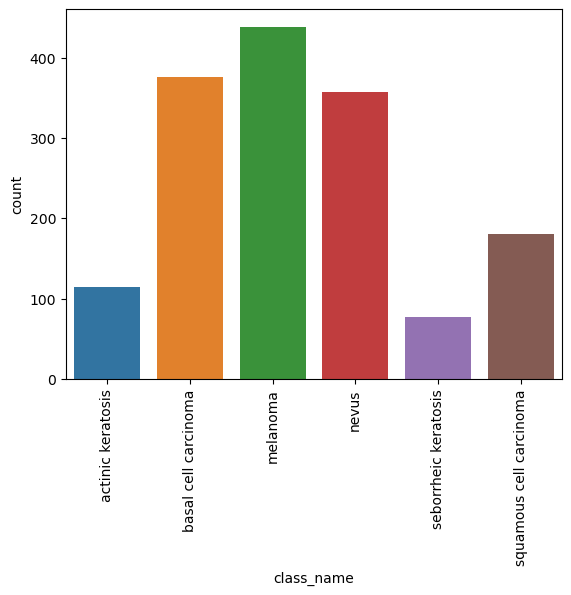

In [134]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### Rectifying the class imbalance

In [19]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/le2/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to /le2/working/data/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17B851513D0>: 100%|██████████| 1000/1000 [00:17<00:00, 56.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /le2/working/data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17B837D1820>: 100%|██████████| 1000/1000 [00:17<00:00, 56.32 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to /le2/working/data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17B8380D640>: 100%|██████████| 1000/1000 [01:43<00:00,  9.68 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to /le2/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x17B85584430>: 100%|██████████| 1000/1000 [01:20<00:00, 12.37 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to /le2/working/data/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x17B8383B070>: 100%|██████████| 1000/1000 [00:44<00:00, 22.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /le2/working/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17B85139400>: 100%|██████████| 1000/1000 [00:18<00:00, 54.18 Samples/s]                 


In [7]:
output_dir = pathlib.Path('/le2/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

6000


### Distribution of augmented data after adding new images to the original training data.

total training image count = 6000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.16666666666666666
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.16666666666666666
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.16666666666666666
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.16666666666666666
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.16666666666666666
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.16666666666666666
-------------------------------------


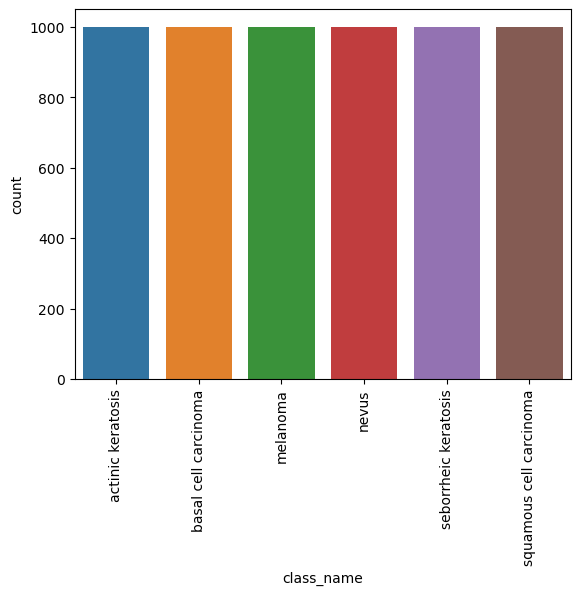

In [8]:
import seaborn as sns
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
    
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [12]:
#train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: name 'output_dir' is not defined

In [13]:
#validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: name 'output_dir' is not defined

In [11]:
print(train_ds.class_names)

NameError: name 'train_ds' is not defined

#  OUR MODEL

In [30]:
#Adding required layers to the CNN MODEL
num_classes = 6
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=6, activation= 'sigmoid'))


In [135]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 128)      

In [31]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [32]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
150/150 [==============================] - 328s 2s/step - loss: 1.7031 - accuracy: 0.2365 - val_loss: 1.4502 - val_accuracy: 0.3333
Epoch 2/25
150/150 [==============================] - 325s 2s/step - loss: 1.3374 - accuracy: 0.3890 - val_loss: 1.3750 - val_accuracy: 0.3600
Epoch 3/25
150/150 [==============================] - 331s 2s/step - loss: 1.2513 - accuracy: 0.4252 - val_loss: 1.1891 - val_accuracy: 0.4558
Epoch 4/25
150/150 [==============================] - 328s 2s/step - loss: 1.2212 - accuracy: 0.4535 - val_loss: 1.2421 - val_accuracy: 0.4442
Epoch 5/25
150/150 [==============================] - 331s 2s/step - loss: 1.1338 - accuracy: 0.5063 - val_loss: 1.1156 - val_accuracy: 0.5192
Epoch 6/25
150/150 [==============================] - 329s 2s/step - loss: 1.0706 - accuracy: 0.5427 - val_loss: 1.0264 - val_accuracy: 0.5725
Epoch 7/25
150/150 [==============================] - 293s 2s/step - loss: 1.0416 - accuracy: 0.5612 - val_loss: 0.9824 - val_accuracy: 0.5775

#### ACCURACY OF THE CREATED MODEL 

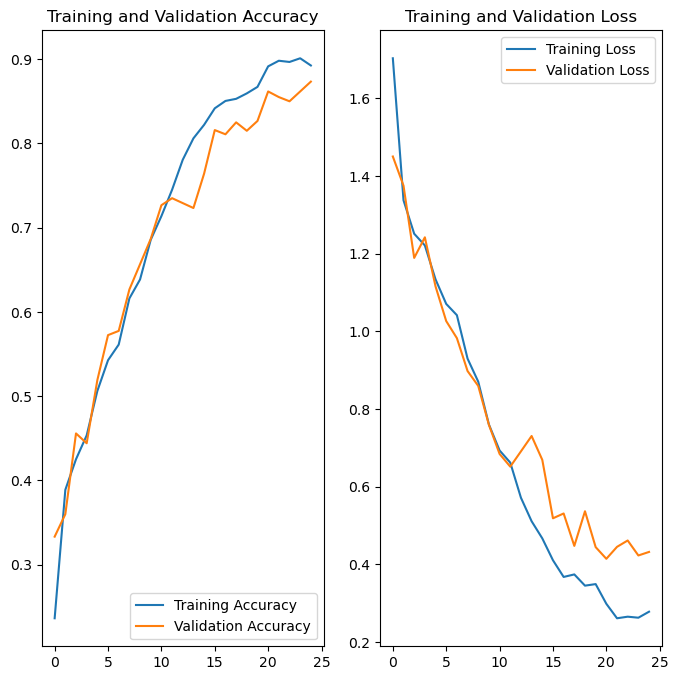

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [143]:
print('ACCURACY : ',acc[-1])
print('VALIDATION ACCURACY : ',val_acc[-1])

ACCURACY :  0.8924999833106995
VALIDATION ACCURACY :  0.8733333349227905


In [43]:
#Create a file to save models
top_model_weights_path = 'final_model/cnn_sigmoid_model.h5'
model.save(top_model_weights_path)

# MODULE 2: SHORLISTING SKIN DISEASES FOR GIVEN USER IMAGE USING CREATED CNN MODEL 

In [6]:
#loading the cnn model
cnn_model = load_model("final_model/cnn_sigmoid_model.h5")

In [7]:
mapping = ['ACK','BCC','MEL','NEV','SEK','SCC']
THRESHOLD = 0.5

In [11]:
#example image
path1='skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000031.jpg'
path2='skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000000.jpg'

In [12]:
#function for finding the diseases above the threshold
def predict_class(pred):  
    shortlist=[]
    l=list(pred)
    m=max(l)
    print(m)
    print(train_ds.class_names[l.index(m)])
    

(-0.5, 179.5, 179.5, -0.5)

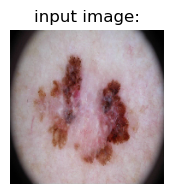

In [13]:
image1 = tf.keras.utils.load_img(path1,target_size=(180, 180))
plt.figure(figsize=(2, 2))
plt.imshow(image1)
plt.title('input image:')
plt.axis("off")

In [31]:
#function for finding the diseases above the threshold
def print_threshold(pred):  
    l=list(pred)
    for i in l:
        print(train_ds.class_names[l.index(i)], ' -  ', i)

In [33]:
input_arr = tf.keras.utils.img_to_array(image1)
input_arr = np.array([input_arr])  
predictions = cnn_model.predict(input_arr)
print_threshold(predictions[0])
        
predict_class(predictions[0])

1/1 [==============================] - 0s 50ms/step
actinic keratosis  -   0.0007124477
basal cell carcinoma  -   0.0073406794
melanoma  -   0.99986964
nevus  -   0.7799105
seborrheic keratosis  -   0.80132574
squamous cell carcinoma  -   0.9991924
0.99986964
melanoma


(-0.5, 179.5, 179.5, -0.5)

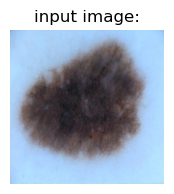

In [34]:
image2 = tf.keras.utils.load_img(path2,target_size=(180, 180))
plt.figure(figsize=(2, 2))
plt.imshow(image2)
plt.title('input image:')
plt.axis("off")

In [35]:
input_arr = tf.keras.utils.img_to_array(image2)
input_arr = np.array([input_arr])  
predictions = cnn_model.predict(input_arr)
print_threshold(predictions[0])     
predict_class(predictions[0])

1/1 [==============================] - 1s 572ms/step
actinic keratosis  -   0.0016167016
basal cell carcinoma  -   0.05517026
melanoma  -   0.9956836
nevus  -   0.9999318
seborrheic keratosis  -   0.21816461
squamous cell carcinoma  -   0.00012866045
0.9999318
nevus
